In [5]:
%pylab inline
from numpy import genfromtxt
import numpy as np
import scipy as sp
import scipy.signal as sps
from scipy import interpolate

# Import custom modules
import sys, os
sys.path.append(os.path.join(os.path.expanduser('~'),'Ch6.DePitta.GPCR/pycustommodules'))
# import pycustommodules.save_utils as svu
import save_utils as svu
import general_utils as gu
import solvers.solver_utils as su
sys.path.append(os.path.join(os.path.expanduser('~'),'Ch6.DePitta.GPCR/code'))
import astrocyte_models as models

#-------------------------------------------------------------------------------------------------------------------------
# Utilites
#-------------------------------------------------------------------------------------------------------------------------
# Data normalization
normalize = lambda data : (data-np.amin(data))/(np.amax(data)-np.amin(data))

# Retrieve indexes of relative min/max
def relextrema(data):
    mx = sps.argrelextrema(data,np.greater)[0]
    mn = sps.argrelextrema(data,np.less)[0]
    thr = 20 # Threshold number of points
    df = 0
    imx = [mx[0]]
    imn = [mn[0]]
    # Compute relative maxima
    for i in xrange(1,np.size(mx)):
        if np.diff(mx[[df,i]]) >= thr:
            df = i
            imx.append(mx[i])
        else :
            if data[mx[i]] > data[mx[i-1]]:
                del imx[-1]
                imx.append(mx[i])
    # Compute relative minima
    df = 0            
    for i in xrange(1,np.size(mn)):
        if np.diff(mn[[df,i]]) >= thr:
            df = i
            imn.append(mn[i])
        else :
            if data[mn[i]] < data[mn[i-1]]:
                del imn[-1]
                imn.append(mn[i])
    return imn, imx

Populating the interactive namespace from numpy and matplotlib


In [6]:
########################################
## p_open.pkl
########################################
# Get data from Figs. 6,7 by Romeros-Franco et al. (BJ 2000) 
p_ca = (genfromtxt('popen_ca.csv', delimiter=',')).round(2).T
p_ip3 = (genfromtxt('popen_ip3.csv', delimiter=',')).round(2).T

# Convert in uM
p_ca[0] = 10.0**p_ca[0]/1e-6
p_ip3[0] = 10.0**p_ip3[0]/1e-6

# Save in final dictionary
p_open = {'ca': p_ca, 'ip3': p_ip3}
# svu.savedata([p_open],'p_open.pkl')

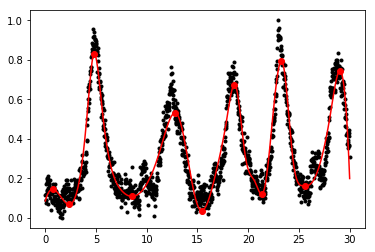

In [7]:
########################################
## herzog_data.pkl
########################################
# Import and save calcium traces from original experiments in vitro by N. Herzog (2013, Tel Aviv University).
# The traces are cut for convenience at 30s and a smoothed copy on which to perform fitting is stored for reconstruction
# in the optimization problem
import numpy as np
import scipy.io as io
import matplotlib.pylab as plt
cbc = io.loadmat('data_CBC.mat') # Load sample Ca2+ traces from in vitro experiments
ca_traces = {'time'     : [None] * 4, 
             'original' : [None] * 4,
             'smoothed' : [None] * 4,
             'mean'     : [None] * 4,
             'imin'     : [None] * 4,
             'imax'     : [None] * 4
            }

for tr in xrange(np.shape(cbc['x'])[1]):
    index = cbc['x'][:,tr] <= 30
    ca_tr_norm = normalize(cbc['y'][index,tr])
    if tr==3:
        smoothing = 7
    else:
        smoothing = 5
    ca_tck = interpolate.UnivariateSpline(cbc['x'][index,tr], ca_tr_norm, k=3, s=smoothing)
    ca_traces['time'][tr] = cbc['x'][index,tr]
    ca_traces['original'][tr] = ca_tr_norm
    ca_traces['smoothed'][tr] = ca_tck(ca_traces['time'][tr])
    # Extract rel max/min
    ca_traces['imin'][tr], ca_traces['imax'][tr] = relextrema(ca_traces['smoothed'][tr])
    # Temporary save original traces wherefrom to compute mean at the end
    ca_traces['mean'][tr] = cbc['y'][index,tr]
# Create vertical arrays
for k in ca_traces.keys():
    if k not in ['mean','imin','imax']:
        np.vstack(ca_traces[k])
# Deal with mean traces
ca_traces['mean'] = normalize(np.mean(np.vstack(ca_traces['mean']),axis=0))
ca_mnk = interpolate.UnivariateSpline(cbc['x'][index,tr], ca_traces['mean'], k=3, s=5)
ca_traces['mean_smoothed'] = ca_mnk(ca_traces['time'][0])
ca_traces['mean_imin'], ca_traces['mean_imax'] = relextrema(ca_traces['smoothed'][tr])

# # Verify individual smoothed traces
iset = 3
index = np.sort(np.r_[ca_traces['imin'][iset],ca_traces['imax'][iset]])
plt.plot(ca_traces['time'][iset],ca_traces['original'][iset],'k.',
         ca_traces['time'][iset],ca_traces['smoothed'][iset],'r-',
         ca_traces['time'][iset][index],ca_traces['smoothed'][iset][index],'ro')

# Save data
# svu.savedata([ca_traces],'herzog_data.pkl')

[ 7.75917344  5.49907896  0.16272856  0.5         1.        ]


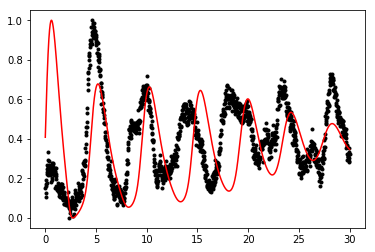

In [9]:
#------------------------------------------
# Check fit results for the Li-Rinzel model
#------------------------------------------
# Load relevant data
ca_data = svu.loaddata('../data/herzog_data.pkl')[0]
po_data = svu.loaddata('../data/fit_po.pkl')[0]

# Original data
plt.plot(ca_traces['time'][0],ca_traces['mean'],'k.')

# Colors for different data sets
colors = ['r','m','b','k','g','c','y']
for i in xrange(1):
    x_rescaled = svu.loaddata('../data/fit_lra.pkl')[0]
    print x_rescaled
    astro = models.Astrocyte(model='lra',
                          d1=po_data[0],d2=po_data[1],d3=po_data[0],d5=po_data[2],a2=po_data[3],
                          c0=5.0,c1=0.5,rc=x_rescaled[0],rl=0.1,ver=x_rescaled[1],Ker=0.1,ip3=x_rescaled[2],
                          ICs=np.asarray([x_rescaled[3],x_rescaled[4]]))
    # Integrate
    options = su.solver_opts(t0=ca_data['time'][0][0], tfin=ca_data['time'][0][-1], dt=1e-4, atol=1e-8, rtol=1e-6, method="gsl_msadams")
    astro.integrate(algparams=options, normalized=True)
    plt.plot(astro.sol['ts'],astro.sol['ca'],color=colors[i],ls='-')
    del astro

[ 0.13964517  0.00222436  0.10745347  0.81536738  0.19930067  0.97504896
  0.19328965]
[ 0.11244662  0.01753451  0.15482272  0.66953736  0.48426103  0.99319175
  0.17905456]
[ 0.1408348   0.02517447  0.16334368  0.86030305  0.09749234  0.97154345
  0.19017563]


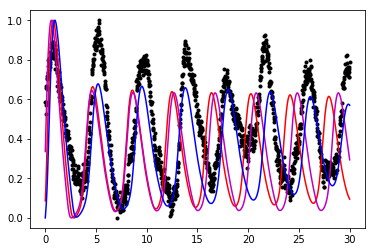

In [11]:
#------------------------------------------
# Check fit results for the Chi model
#------------------------------------------
# Load relevant data
ca_data = svu.loaddata('../data/herzog_data.pkl')[0]
po_data = svu.loaddata('../data/fit_po.pkl')[0]
lr_data = svu.loaddata('../data/fit_lra.pkl')[0]
c0 = 5.0
iset = 2

# Original data
plt.plot(ca_data['time'][iset],ca_data['original'][iset],'k.')

# Colors for different data sets
colors = ['r','m','b']
filename = 'chi_fit_0'
algo = ['pso','de','bee']
for i in xrange(0,3):
    x_rescaled = svu.loaddata(filename+'_'+algo[i]+'.pkl')[0]
    print x_rescaled
    # Fitted data
    astro = models.Astrocyte(model='chi',
                      d1=po_data[0],d2=po_data[1],d3=po_data[0],d5=po_data[2],a2=po_data[3],
                      c0=c0,c1=0.5,rl=0.1,Ker=0.1,rc=lr_data[0],ver=lr_data[1],
                      vbeta=x_rescaled[0], vdelta=x_rescaled[1], v3k=x_rescaled[2], r5p=x_rescaled[3],
                      ICs=np.asarray([x_rescaled[6],x_rescaled[4],x_rescaled[5]]))
    options = su.solver_opts(t0=ca_data['time'][iset][0], tfin=ca_data['time'][iset][-1], dt=1e-4, atol=1e-8, rtol=1e-6, method="gsl_msadams")
    astro.integrate(algparams=options, normalized=True)
    plt.plot(astro.sol['ts'],astro.sol['ca'],color=colors[i],ls='-')
    del astro

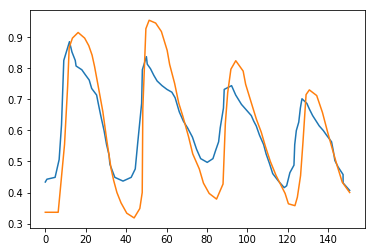

In [12]:
#-----------------------------------------------
# PKC data from Codazzi et al., Curr. Biol. 2001
#-----------------------------------------------
ca_data = genfromtxt('ca_osc.csv', delimiter=',')
pkc_data = genfromtxt('pkc.csv', delimiter=',')
# replace x0 and x_end to make them the same
pkc_data[0,0] = ca_data[0,0]
pkc_data[-1,0] = ca_data[-1,0]
# Align to zero
ca_data[:,0] = ca_data[:,0]-ca_data[0,0]
pkc_data[:,0] = pkc_data[:,0]-pkc_data[0,0]
# Normalize
#ca_data[:,1] = norm(ca_data[:,1])
#pkc_data[:,1] = norm(pkc_data[:,1])
plot(ca_data[:,0],ca_data[:,1])
plot(pkc_data[:,0],pkc_data[:,1])

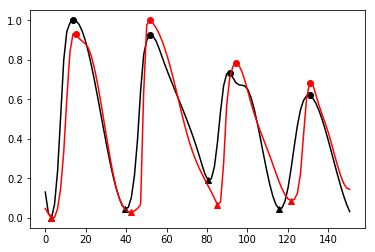

In [13]:
# Create interpolation
npts = 100
xp = np.linspace(ca_data[0,0],ca_data[-1,0],npts)
ca_tck = interpolate.UnivariateSpline(ca_data[:,0], ca_data[:,1], k=3, s=0.05)
pkc_tck = interpolate.UnivariateSpline(pkc_data[:,0], pkc_data[:,1], k=3, s=0.02)

# Generate output data
ca_trace = {}
ca_trace['time'] = xp
ca_trace['original'] = {'ca': ca_data, 'pkc': pkc_data}
ca_trace['smoothed'] = {'ca': normalize(ca_tck(xp)), 'pkc': normalize(pkc_tck(xp))}
cmin, cmax = relextrema(ca_trace['smoothed']['ca'])
pmin, pmax = relextrema(ca_trace['smoothed']['pkc'])
ca_trace['imin'] = {'ca': cmin, 'pkc': pmin}
ca_trace['imax'] = {'ca': cmax, 'pkc': pmax}

# Check results
plt.plot(ca_trace['time'],ca_trace['smoothed']['ca'],'k-',
         ca_trace['time'][cmin],ca_trace['smoothed']['ca'][cmin],'k^',
         ca_trace['time'][cmax],ca_trace['smoothed']['ca'][cmax],'ko')
plt.plot(ca_trace['time'],ca_trace['smoothed']['pkc'],'r-',
         ca_trace['time'][pmin],ca_trace['smoothed']['pkc'][pmin],'r^',
         ca_trace['time'][pmax],ca_trace['smoothed']['pkc'][pmax],'ro')

# Save data
# svu.savedata([ca_trace],'codazzi_data.pkl')